In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

In [2]:
def Bilinear2(orig_image, new_width, new_height):
    new_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    for i in range(new_height):
        for j in range(new_width):
            x = j / (new_width - 1) * (orig_image.shape[1] - 1)
            y = i / (new_height - 1) * (orig_image.shape[0] - 1)
            x1 = int(x)
            y1 = int(y)
            x2 = x1 + 1
            y2 = y1 + 1
            if x2 >= orig_image.shape[1]:
                x2 = x1
            if y2 >= orig_image.shape[0]:
                y2 = y1
            dx = x - x1
            dy = y - y1
            new_image[i, j] = (1 - dx) * (1 - dy) * orig_image[y1, x1] + dx * (1 - dy) * orig_image[y1, x2] + (1 - dx) * dy * orig_image[y2, x1] + dx * dy * orig_image[y2, x2]
    return new_image

In [3]:
def Bilinear(orig_image, new_width, new_height):
    new_x, new_y = np.meshgrid(np.arange(new_height), np.arange(new_width))
    orig_x = new_x / (new_width - 1) * (orig_image.shape[1] - 1)
    orig_y = new_y / (new_height - 1) * (orig_image.shape[0] - 1)
    x1 = orig_x.astype(int)
    y1 = orig_y.astype(int)
    x2 = np.clip(x1 + 1, 0, orig_image.shape[1] - 1)
    y2 = np.clip(y1 + 1, 0, orig_image.shape[0] - 1)
    dx = orig_x - x1
    dy = orig_y - y1
    dx = np.expand_dims(dx, axis=-1)
    dy = np.expand_dims(dy, axis=-1)
    result = (1 - dx) * (1 - dy) * orig_image[y1, x1] + \
             dx * (1 - dy) * orig_image[y1, x2] + \
             (1 - dx) * dy * orig_image[y2, x1] + \
             dx * dy * orig_image[y2, x2]
    return result.astype(np.uint8)

In [4]:
labels = ['NoHand','OpenHand','ClosedHand']
y_train_pos = []
y_train_ges = []
x_train = []
path = "Data/PNG_A/Images"
pos = "Data/PNG_A/Positions"
res = [300, 400]
for i in os.listdir(path):
    for j in os.listdir(path + "/" + i):
        im =  Image.open(path + "/" + i + '/' + j)
        im = np.array(im)
        im = Bilinear(im, 256, 256)
        #im = im/255.0
        x_train.append(im)
        f = open(pos + "/" + i + "/" + j.split(".")[0] + ".txt", "r")
        temp = f.read().split()
        for k in range(2):
            cord = int(temp[k])
            if cord >= 0:
                temp[k] = cord/res[k]*256
            else:
                temp[k] = cord
        y_train_pos.append(temp)
        y_train_ges.append(labels.index(i))
        f.close()

x = np.array(x_train)
y_pos = np.array(y_train_pos)
y_ges = tf.keras.utils.to_categorical(y_train_ges)

print(x.shape)
print(y_pos.shape)
print(y_ges.shape)

(1500, 256, 256, 3)
(1500, 2)
(1500, 3)


In [5]:
from sklearn.model_selection import train_test_split

# Split the data for the position labels
x_train_split, x_val, y_train_split_pos, y_val_pos = train_test_split(x, y_pos, train_size=0.80, random_state=42)

# Split the data for the gesture labels
temp1, temp2, y_train_ges, y_val_ges = train_test_split(x, y_ges, train_size=0.80, random_state=42)

In [6]:
input = tf.keras.layers.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
f = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation='relu')(f)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(f)
x = tf.keras.layers.Dense(128, activation='relu')(x)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(x)
gesture_output = tf.keras.layers.Dense(3, activation='softmax', name="gesture_output")(x)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(x)

x = tf.keras.layers.Dense(256, activation='relu')(f)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(f)
x = tf.keras.layers.Dense(128, activation='relu')(x)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(x)
position_output = tf.keras.layers.Dense(2, name="position_output")(x)#, kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01,l2 = 0.1), bias_regularizer=tf.keras.regularizers.l2(0.1))(x)

model = tf.keras.Model(input, [gesture_output, position_output])

model.summary()

checkpoint_filepath = "checkpoints_position/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer='adam', loss={"position_output": "mse", "gesture_output": "categorical_crossentropy"}, metrics={"position_output": "mae", "gesture_output": "accuracy"})

model.fit(x_train_split, {"gesture_output": y_train_ges, "position_output": y_train_split_pos}, epochs=1000, batch_size=32, validation_data=(x_val, {"gesture_output": y_val_ges, "position_output": y_val_pos}), callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 254, 254, 16)         448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 125, 125, 32)         4640      ['max_pooling2d[0][0]'] 

In [7]:
# Execute Cell Index 3 first to define and train the model

model.evaluate(x_val, {"gesture_output": y_val_ges, "position_output": y_val_pos})


10/10 [==============================] - 1s 55ms/step - loss: 12.4140 - gesture_output_loss: 0.0387 - position_output_loss: 12.3753 - gesture_output_accuracy: 0.9933 - position_output_mae: 2.3096


[12.414040565490723,
 0.03871338069438934,
 12.375326156616211,
 0.9933333396911621,
 2.309624433517456]

1/1 [==============================] - 0s 24ms/step
[array([[2.4313972e-30, 1.0000000e+00, 2.4899374e-09]], dtype=float32), array([[ 43.15667, 178.09325]], dtype=float32)]


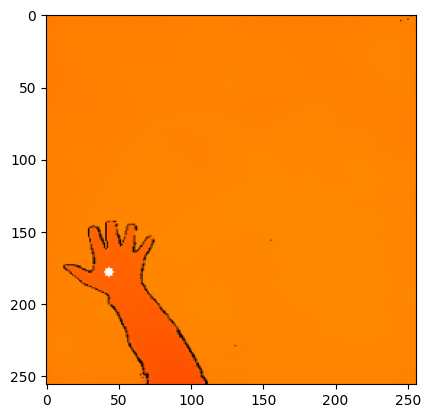

In [42]:
im = x_val[133].copy()
predictions = model.predict(im.reshape(1, 256, 256, 3))

print(predictions)

x_pos = int(predictions[1][0][0])
y_pos = int(predictions[1][0][1])

for x in range(256):
    for y in range(256):
        if((x - x_pos)**2 + (y - y_pos)**2 < 10):
            im[y][x] = [255, 255, 255]

import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()




In [23]:
import tf2onnx

tf2onnx.convert.from_keras(model, output_path="AIOv3.onnx")

(ir_version: 8
 producer_name: "tf2onnx"
 producer_version: "1.16.1 15c810"
 graph {
   node {
     input: "input_3"
     output: "model_2/conv2d_8/BiasAdd__50:0"
     name: "model_2/conv2d_8/BiasAdd__50"
     op_type: "Transpose"
     attribute {
       name: "perm"
       ints: 0
       ints: 3
       ints: 1
       ints: 2
       type: INTS
     }
   }
   node {
     input: "model_2/conv2d_8/BiasAdd__50:0"
     input: "model_2/conv2d_8/Conv2D/ReadVariableOp:0"
     input: "model_2/conv2d_8/BiasAdd/ReadVariableOp:0"
     output: "model_2/conv2d_8/BiasAdd:0"
     name: "model_2/conv2d_8/BiasAdd"
     op_type: "Conv"
     attribute {
       name: "dilations"
       ints: 1
       ints: 1
       type: INTS
     }
     attribute {
       name: "strides"
       ints: 1
       ints: 1
       type: INTS
     }
     attribute {
       name: "kernel_shape"
       ints: 3
       ints: 3
       type: INTS
     }
     attribute {
       name: "group"
       i: 1
       type: INT
     }
     doma

[array([[176.2733 , 147.24823]], dtype=float32)]


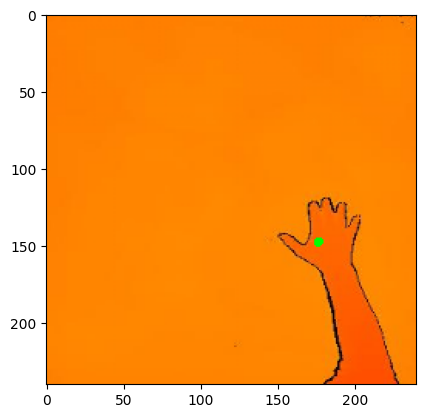

In [11]:
import onnxruntime
import matplotlib.pyplot as plt

img = Image.open("Data/JPG/Images/OpenHand/25.jpg")
#img = img.resize((240,240), Image.BILINEAR)
img = Bilinear(np.array(img), 240, 240)
img = np.array(img)


# Load the ONNX model
sess = onnxruntime.InferenceSession("hand_positionV3.onnx")
intput_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
image = img.astype(np.float32)

onnx_predicted_label = sess.run(output_names=[output_name], input_feed={intput_name: image.reshape(1,240,240,3)})
print(onnx_predicted_label)

for x in range(240):
    for y in range(240):
        if((x - onnx_predicted_label[0][0][0])**2 + (y - onnx_predicted_label[0][0][1])**2 < 10):
            img[y][x] = [0, 255, 0]

plt.imshow(img)
plt.show()

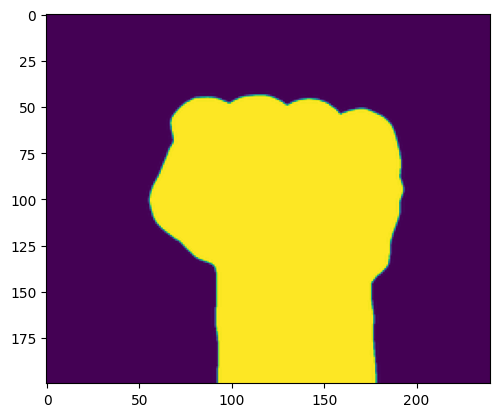

(1, 200, 240, 1)


In [41]:
img = Image.open("okay3.png")
for i in range(img.size[0]):
    for j in range(img.size[1]):
        if img.getpixel((i, j))[0] > 230 and img.getpixel((i, j))[1] > 230 and img.getpixel((i, j))[2] > 230:
            img.putpixel((i, j), (0,0,0))
        else:
            img.putpixel((i, j), (255, 255, 255))
img = img.convert('L')
img = img.resize((240, 200), Image.LANCZOS)
img = np.array(img)
plt.imshow(img)
plt.show()
img = img.reshape(1, 200, 240, 1)
print(img.shape)


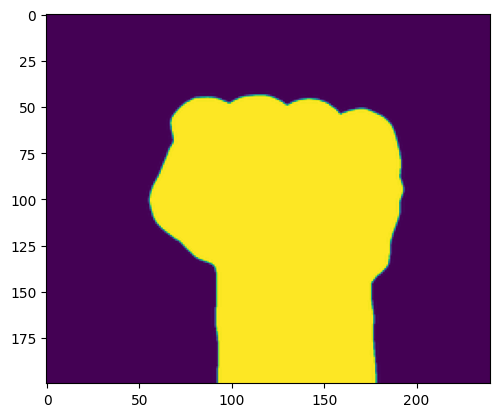

rock
[array([[3.1971749e-07, 1.3945986e-08, 9.9999964e-01]], dtype=float32)]


In [42]:
predictions = onnx_predicted_label = sess.run(output_names=[output_name], input_feed={intput_name: img.astype(np.float32)})
plt.imshow(img.reshape(200, 240))
plt.show()
print(labels[np.argmax(predictions)])
print(predictions)

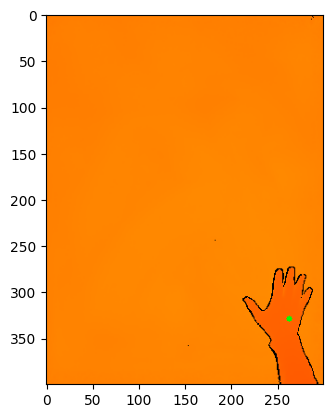

In [23]:
img = Image.open("Data/PNG_A/Images/OpenHand/55.png")
img = np.array(img)
position = open("Data/PNG_A/Positions/OpenHand/55.txt", "r").read().split()
x1 = int(position[0])
y1 = int(position[1])

for x in range(300):
    for y in range(400):
        if((x - x1)**2 + (y - y1)**2 < 10):
            img[y][x] = [0, 255, 0]

plt.imshow(img)
